Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`. A Thorlabs scientific camera(CS2100M-USB) is used to obtain PSF images.

In [1]:
import sys
print(sys.path)

['C:\\Users\\ML2618\\PycharmProjects\\HexSimInstrument', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\python38.zip', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\DLLs', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib', '', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages', 'C:\\Users\\ML2618\\PycharmProjects\\napari-pcd-reader_draft\\src', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32\\lib', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\Pythonwin']


In [2]:
import numpy as np
import cupy as cp
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from IPython import display
from pylablib.devices import Thorlabs
import ctypes as ct
from random import randrange
import subprocess, os
import scipy.ndimage
import cupyx.scipy.ndimage as cpndimage
import opt_einsum as oe

In [3]:
xp = cp
n_bias = 3

In [179]:
print(f'Cameras attached: {Thorlabs.list_cameras_tlcam()}')
cam = Thorlabs.ThorlabsTLCamera()

Cameras attached: ['14403']


In [524]:
cam.close()
slm.deactivate()
slm.close()

Port closed successfully


## SLM's device functions

In [5]:
class Dev(ct.Structure):
    pass
Dev._fields_ = [("id", ct.c_char_p), ("next", ct.POINTER(Dev))]
                
                
class SLMDev():
    """
    Connect to the real-world Methods allow for device read and write functions for R11 SLM.
    """

    def __init__(self):

        self.NULL = ct.POINTER(ct.c_int)()
        self.RS485_DEV_TIMEOUT = ct.c_uint16(1000)
        self.r11 = ct.windll.LoadLibrary('C:/Program Files/MetroCon-4.1/R11CommLib-1.8-x64.dll')
        self.xpix = 2048
        self.ypix = 2048
        self.xv, self.yv = self.interleaving()
        
    def initiate(self):
        ver = ct.create_string_buffer(8)
        maxlen = ct.c_uint8(10)
        res = self.r11.R11_LibGetVersion(ver, maxlen)
        if (res == 0):
            print('Software version: %s' % ver.value)
        else:
            raise Exception('Libarary not loaded')
        guid = ct.c_char_p(b"54ED7AC9-CC23-4165-BE32-79016BAFB950")
        devcount = ct.c_uint16(0)
        devlist = ct.POINTER(Dev)()
        res = self.r11.FDD_DevEnumerateWinUSB(guid, ct.pointer(devlist), ct.byref(devcount))
        if res == 0:
            port = devlist.contents.id.decode()
            print('Dev port: %s' % port)
        else:
            raise Exception('Cannot find the port')

    def open_usb_port(self):
        port = ct.c_char_p(b'\\\\?\\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}')
        re = self.r11.FDD_DevOpenWinUSB(port, self.RS485_DEV_TIMEOUT)
        if re == 0:
            print('Open Dev port successfully')
            dispTemp = ct.c_uint16(0)
            self.r11.R11_RpcSysGetDisplayTemp(ct.byref(dispTemp))
            print('Display temperature: %s' % dispTemp.value)
        else:
            raise Exception(' Fail to open the port ')

    def activate(self,):
        res = self.r11.R11_RpcRoActivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to activate SLM. Error code: {res}')

    def deactivate(self):
        res = self.r11.R11_RpcRoDeactivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to deactivate. Error code: {res}')

    def getordernum(self):
        rocount = ct.c_uint16(0)
        res = self.r11.R11_RpcRoGetCount(ct.byref(rocount))
        if res == 0:
            num = rocount.value
            print('order number: %s' % num)
        else:
            raise Exception('Fail to get the order number')

    def getActivationType(self):
        """Retrieve the activation typr of the currently loaded running order"""
        actType = ct.c_uint8(0)
        res = self.r11.R11_RpcRoGetActivationType(ct.byref(actType))
        if res == 0:
            return actType.value
        else:
            raise Exception('Failed to get activation type')

    def getRO(self):
        roindex = ct.c_uint16(0)
        res_index = self.r11.R11_RpcRoGetSelected(ct.byref(roindex))
        roName = ct.create_string_buffer(255)
        res_name = self.r11.R11_RpcRoGetName(roindex, roName, len(roName))
        if (res_index == 0) & (res_name == 0):
            return roindex.value, roName.value
        elif res_index != 0:
            raise Exception('Failed to get RO index')
        elif res_name != 0:
            raise Exception('Failed to get RO name')

    def getRepName(self):
        """Retrieve the name of the repertoire loaded on the board."""
        repName = ct.create_string_buffer(255)
        re = self.r11.R11_RpcSysGetRepertoireName(repName, len(repName))
        if re == 0:
            return repName.value
        else:
            raise Exception('Failed to get repertoire name')

    def setRO(self, n):
        roindex = ct.c_uint16(n)
        res = self.r11.R11_RpcRoSetSelected(roindex)
        if res == 0:
            num = roindex.value
            print(f'Order is set to {num}')
        else:
            raise Exception('Failed to set the order')

    def getState(self):
        actState = ct.c_uint8(0)
        self.r11.R11_RpcRoGetActivationState(ct.byref(actState))
        return actState.value

    def close(self):
        res = self.r11.FDD_DevClose()
        if res == 0:
            print('Port closed successfully')
        else:
            raise Exception('Fail to closE R11 SLM')

    def interleaving(self):
        x0 = xp.zeros(self.xpix)
        y0 = xp.arange(self.ypix)

        nr = xp.arange(8)
        for i in range(64):
            x0[(i * 32):(i * 32 + 8)] = nr + i * 8
            x0[(i * 32 + 8):(i * 32 + 16)] = nr + i * 8 + 512
            x0[(i * 32 + 16):(i * 32 + 24)] = nr + i * 8 + 1024
            x0[(i * 32 + 24):(i * 32 + 32)] = nr + i * 8 + 1536
        # x0 is now an array of interleaved x values in the correct places for sending to the SLM

        x, y = xp.meshgrid(x0, y0)
        return x, y

    def sendBitplane(self, data, frameno):
        print(f'sending frame number {frameno}')
        t0 = time.time()
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256
            # Flash blocks per bitplane: 4
            # Flash pages per bitplane: 256
            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
            if res != 0:
                raise Exception(f'Fail to erase block {block}')
            for page in range(64):
                buf = np.uint8(data[(block * 64 + page) * 2048:(block * 64 + page) * 2048 + 2048])
                res = self.r11.R11_FlashWrite(buf.ctypes.data_as(ct.POINTER(ct.c_uint8)), ct.c_uint16(0),
                                              ct.c_uint16(2048))
                if res != 0:
                    raise Exception(f'Fail write block {block}: page {page}')
                page_address = ct.c_uint32(block_address + page)
                res = self.r11.R11_FlashBurn(page_address)
                if res != 0:
                    raise Exception(f'Fail burn block {block}: page {page}')
        print(f'bitplane sent in {time.time() - t0}')

    def eraseBitplane(self, frameno):
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256

            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
        if res == 0:
            print(f'Frame number {frameno} erased')
        else:
            raise Exception(f'Fail to erase block {block}')

    def repReload(self):
        res = self.r11.R11_RpcSysReloadRepertoire()
        t0 = time.time()
        while self.getProgress() != 100:
            self.getProgress()
        t = time.time() - t0
        print(f'Elapsed time of reloading: {t}')
        if res != 0:
            raise Exception('Fail reload repertoire')

    def getProgress(self):
        """Get the progress of the current board operation."""
        p = ct.c_uint8(0)
        res = self.r11.R11_DevGetProgress(ct.byref(p))
        if res != 0:
            raise Exception(f'Fail to get progress. Error code: {res}')
        return p.value

## SLM's hardware functions

In [6]:
class SLMHar():
    """class to control the SLM hardware"""
    BPins = [None] * n_bias

    def flashCorrection(self, img):
        randImg = randrange(11, 768 - n_bias)
        for i in range(n_bias):
            self.BPins[i] = randImg + i  # bit planes index
        for k in range(n_bias):
            slm.sendBitplane(img[k], self.BPins[k])

            
    def writeCorrRep(self, fns, imgns='hol.png'):
        """write a text file of the SLM correction repertoire and save it as '.rep' format,and then build it to a '.repz11' file."""
        os.chdir('C:/Users/ML2618/Desktop/SLMtests')
        with open(f'{fns}.txt', 'w') as f:
            data = ("ID\n"
                    '"V1.0 ${date(\\"yyyy-MMM-dd HH:mm:ss\\")}"\n'
                    "ID_END\n\n"
                    "PLATFORM\n"
                    '"R11"\n'
                    "PLATFORM_END\n\n"
                    "DISPLAY\n"
                    '"2Kx2K"\n'
                    "DISPLAY_END\n\n"
                    "FORMATVERSION\n"
                    '"FV4"\n'
                    "FORMATVERSION_END\n\n"
                    "SEQUENCES\n")
            f.write(data)

            data2 = ('A "48160 1ms 1-bit Balanced.seq11"\n'
                     'SEQUENCES_END\n\n'
                     'IMAGES\n')
            f.write(data2)

            for i in range(n_bias):
                data3 =(f' 1 "{imgns}"\n')
                f.write(data3)

            data4 = ('IMAGES_END\n'
                     f'DEFAULT "R0{self.BPins[0]}"\n'
                    '[HWA \n'
                    f'<(A, {self.BPins[0]}) >\n'
                    ']\n')
            f.write(data4)
            
            for k in range(1, n_bias):
                data5 = (f'"R0{self.BPins[k]}"\n'
                    '[HWA \n'
                    f'<(A, {self.BPins[k]}) >\n'
                    ']\n')
    
                f.write(data5)

        os.rename(f'{fns}.txt', f'{fns}.rep')
        print('New rep file created')

        # build the rep to a repz11 file
        print(os.getcwd())
        output = subprocess.run(['RepBuild', fns + '.rep', '-c', fns + '.repz11'], shell=True,
                                stdout=subprocess.PIPE)
        if output.returncode == 0:
            print(output.stdout.decode())
            print('repz11 file created')
        else:
            print(f'rep to repz11 failed, error: {output.stderr}')

    def repSendBP(self, fn):
        """Send the repz.11 file to the board. fn: file name, e.g. 'test1'"""
        slm.close()
        output = subprocess.run(['RepSender', '-z', fn, '-d', '0175000881', '-i'], shell=True, stdout=subprocess.PIPE)
        if output.returncode == 0:
            print('New repertoire sent without images.')
        else:
            print(f'Repertoire sending without images failed, error: {output.stderr}')
        slm.open_usb_port()
        
    def updateBp(self, img, fn):
        t0 = time.time()
        self.flashCorrection(img)
        self.writeCorrRep(fn)
        self.repSendBP(fn +'.repz11')
        print(f'Repertoire updated in {time.time() - t0}s')

In [180]:
slm = SLMDev()
slm.initiate()
slm.open_usb_port()

Software version: b'1.8.189.'
Dev port: \\?\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}:0175000881
Open Dev port successfully
Display temperature: 5952


In [34]:
har = SLMHar()

## Camera functions

Live camera viewing.

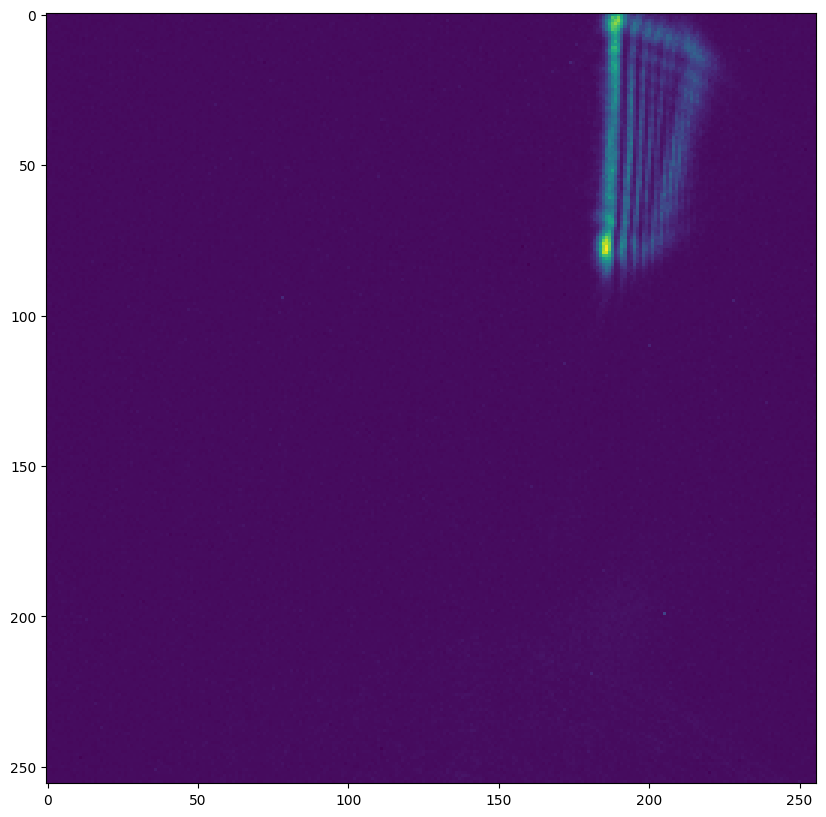

In [361]:
cam.set_exposure(0.01)
# cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
cam.set_roi(hstart=582, hend=838, vstart=207, vend=463, hbin=1, vbin=1)
fig, ax = plt.subplots(figsize=(10,10))
tc0 = time.time()
while time.time() - tc0 < 10:
    frame = cam.snap()
    ax.clear()
    ax.imshow(frame)
    display.clear_output(wait=True)
    display.display(ax.get_figure())
    plt.pause(0.1)

In [518]:
slm.setRO(1)

Order is set to 1


In [331]:
slm.deactivate()

In [490]:
cam.open()

Checking the ROI.

(256, 256)


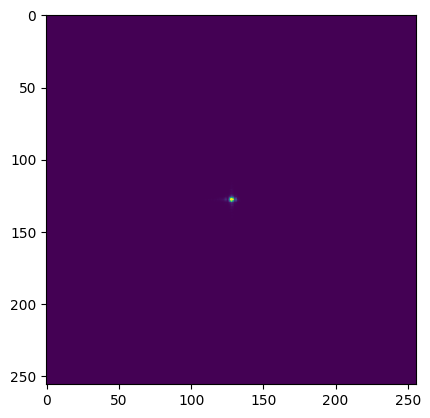

In [523]:
cam.set_exposure(0.01)
cam.set_roi(hstart=650, hend=906, vstart=127, vend=383, hbin=1, vbin=1)
ri = cam.snap()
plt.imshow(ri)
print(ri.shape)

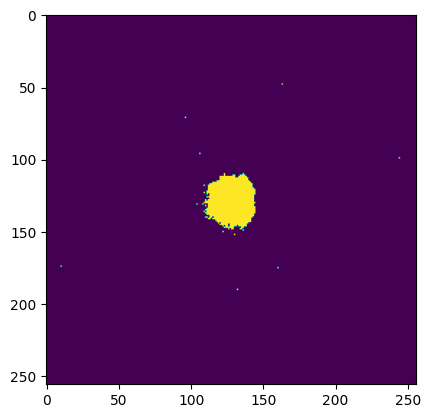

In [124]:
plt.imshow(ri > 180)

Chcking the full screen.

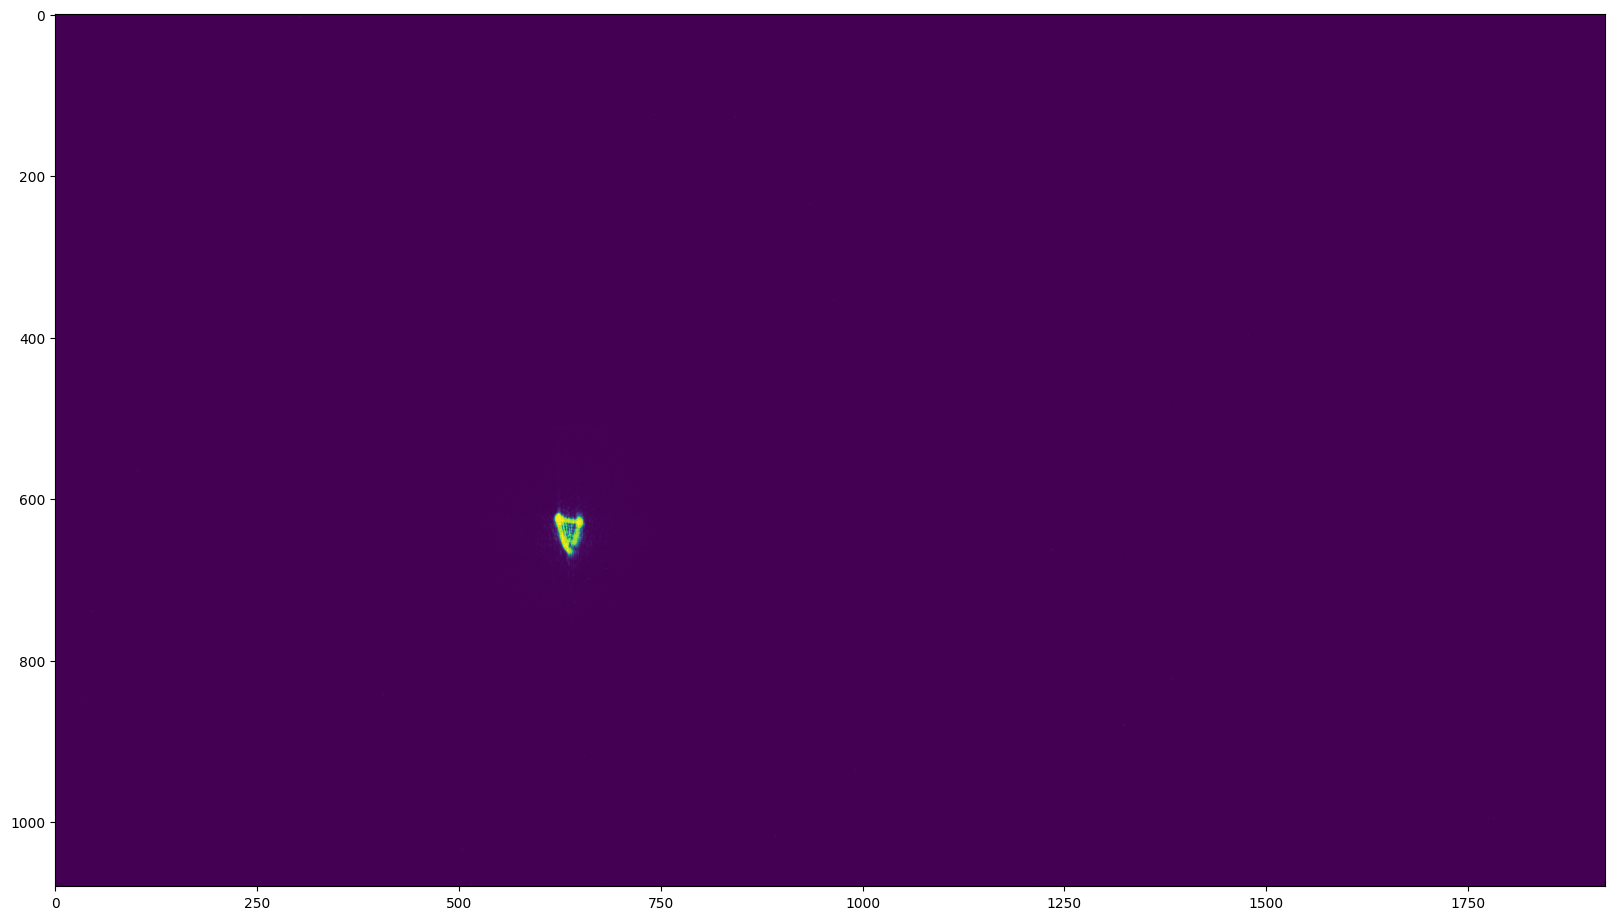

In [444]:
cam.set_exposure(0.1)
cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
ri = cam.snap()
plt.figure(figsize=(20,20))
plt.imshow(ri)

In [285]:
aa = [None, None]

def stable_test(t):
    aa[0] = cam.snap()
    time.sleep(t)
    aa[1] = cam.snap()
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.imshow(aa[i])

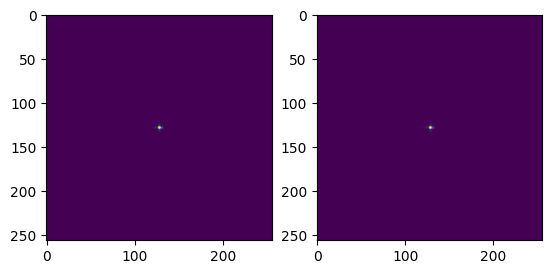

In [395]:
stable_test(0.02)

In [384]:
# tt0 = time.time()
# img = cam.grab(nframes=10, frame_timeout=0.00, missing_frame='skip', return_info=False, buff_size=None)
# # aaa = oe.contract('ijk, ijk -> ijk', (np.array(img) - bg), np.array(img) > bg)
# print(time.time() - tt0)

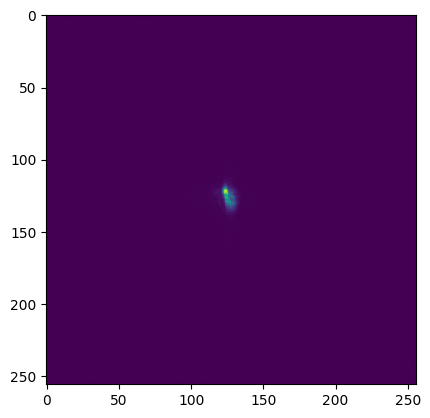

In [339]:
plt.figure()
plt.imshow(img[8])


sumimg = 0
# plt.figure()
# for i in range(10):
#     sumimg += (img[i] - bg) * (img[i] > bg)
# plt.imshow(sumimg)

# plt.figure()
# sumimg = np.sum(aaa, axis=0)
# plt.imshow(sumimg / 10)
# print((sumimg / 10)[128])

cam.wait_for_frame?


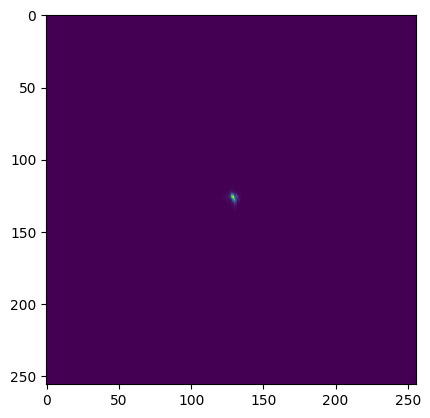

In [91]:
plt.imshow(abc[0])

# Aberration correction

In [35]:
# titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Unwrapped PSF phase difference', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus'
titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Zernike fitted phase', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus']

In [36]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
N = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [37]:
# Sampling in pupil plane
s_p = f * l / (N * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [38]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


Set up arrays

In [39]:
x, y = xp.meshgrid(xp.linspace(-N / d_p, N / d_p, N), xp.linspace(-N / d_p, N / d_p, N))
r = xp.sqrt(x ** 2 + y ** 2)
theta = xp.arctan2(y, x)
circ = r < 1
normval = xp.sum(circ)

In [40]:
N / d_p

1.8431057636469221

Set up arrays and Chebyshev polynomials

In [41]:
xx = xp.linspace(-N / d_p, N / d_p, N)
m = np.abs(xx) < 1
ne = (N - sum(m)) // 2  # 1/2 number of elements along side of pupil
xx *= m

# weight function along 1-d
wtx = (1 / xp.sqrt(1 - (xx ** 2))) * m
# find correctiom to end element that makes Ch[0]*Ch[2]*wtx = 0
s = xp.sum(wtx * (2 * xx ** 2 - 1) )
df = s / (2 * xx[ne] ** 2 - 1) / 2
wtx[ne] -= df
wtx[-ne - 1] = wtx[ne]

# Now calculate 2-d weights
x, y = xp.meshgrid(xx, xx)
circ = xp.outer(m, m)
wt = xp.outer(wtx, wtx)
r = xp.sqrt(x ** 2 + y ** 2)

# weight the target PSF towards the centre (or not if all ones)
G = xp.ones((int(N), int(N)))

n_c = 5

def set_C(xc, yc, n_c, Nc, circ0):
    ch = np.zeros((n_c, n_c, Nc, Nc))
    if xp == cp:
        xc = xc.get()
        yc = yc.get()
        for n in range(n_c):
            for k in range(n_c):
                c = np.zeros((n + 1, k + 1))
                c[n, k] = 1
                ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c) * circ0.get()
        ch = cp.array(ch)
    else:
        for n in range(n_c):
            for k in range(n_c):
                c = np.zeros((n + 1, k + 1))
                c[n, k] = 1
                ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c) * circ0
    return ch
        
chs = set_C(x, y, 5, N, circ)
        
c_a_p = xp.reshape(chs, (n_c ** 2, N, N)) # Chebyshev aberration for phase
c_a_i = c_a_p[:16]  # Chebyshev aberration for intensity   
normval_p = 1 / oe.contract('ijk, ijk, jk -> i', c_a_p, c_a_p, wt)
normval_i = 1 / oe.contract('ijk, ijk, jk -> i', c_a_i, c_a_i, wt)

## SLM's aberration

<div class="alert alert-block alert-success">
<b> PSFs with the aberration are captured by the camera here.</b>
</div>

### Initial input

In [42]:
beams = 1
if xp == cp:
    # place the pixels in negative and positive axes
    xSLM = (xp.array(slm.xv) - slm.xpix / 2) / (slm.xpix)
    ySLM = (xp.array(slm.yv) - slm.ypix / 2) / (slm.ypix)
else:
    # place the pixels in negative and positive axes
    xSLM = (slm.xv - slm.xpix / 2) / (slm.xpix)
    ySLM = (slm.yv - slm.ypix / 2) / (slm.ypix)
    
Phi = xp.random.random((n_bias, slm.ypix, slm.xpix)) * 2 * np.pi
Tau = xp.zeros((beams, slm.ypix, slm.xpix), dtype=xp.double)  # phase tilt
Psi = xp.zeros((n_bias, slm.ypix, slm.xpix), dtype=xp.double)
F = xp.zeros(beams, dtype=xp.complex_)
G = xp.zeros((slm.ypix, slm.xpix, beams), dtype=xp.complex_)
img = [None] * n_bias

Calculte Chebyshev polynomials for 2048 * 2048 pixels

In [43]:
ND = 2048
xd = xp.linspace(-1, 1, ND)
xD = xd[xp.array(slm.yv, dtype=int)]
yD = -xd[xp.array(slm.xv, dtype=int)]

mD = np.abs(xd) < 1
circD = xp.outer(mD, mD)

chsD = set_C(xD, yD, 5, ND, circD)
c_a_pD = xp.reshape(chsD, (n_c ** 2, ND, ND)) # Chebyshev aberration for phase

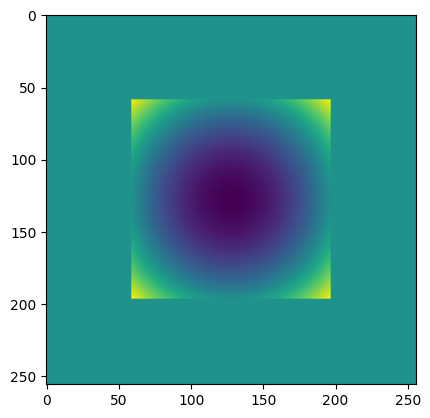

In [484]:
plt.figure(102)
# defocus = 5 * chs[2, 2]
# bias = [5 * chs[2, 2], 0 * (chs[0, 2] + chs[2, 0]), -5 * chs[2, 2]]
# biasD = [5 * chsD[2, 2], 0 * (chsD[0, 2] + chsD[2, 0]), -5 * chsD[2, 2]]

defocus = 2 * (chs[0, 2] + chs[2, 0])
bias = [2 * (chs[0, 2] + chs[2, 0]), 0 * (chs[0, 2] + chs[2, 0]), -2 * (chs[0, 2] + chs[2, 0])]
biasD = [2 * (chsD[0, 2] + chsD[2, 0]), 0 * (chsD[0, 2] + chsD[2, 0]), -2 * (chsD[0, 2] + chsD[2, 0])]

# biasD = [40 * chsD[0, 1], 0 * chsD[1, 1], 40 * chsD[1, 0]]  # simple tilts for testing holograms on SLM

if xp == cp:
    plt.imshow(defocus.get())
else:
    plt.imshow(defocus)

Generate three initial holograms.

In [485]:
nm = 10 ** -9
mm = 0.001
wavelength = 520 * nm
f = 300 * mm
D = 1.9 * mm  # half the distance between the two corrected orders
p = 1 / (D / wavelength / f) / (0.0082 * mm) * 1.2
hex_bits = [None] * n_bias

In [509]:
for i in range(beams):
    xpSLM = slm.xpix / p * 2 * np.pi * cp.cos(2 * i * np.pi / 3 + np.pi / 18)
    ypSLM = slm.ypix / p * 2 * np.pi * cp.sin(2 * i * np.pi / 3 + np.pi / 18)
    Tau[i, :, :] = xSLM * xpSLM + ySLM * ypSLM
    
Psi0 = 0
for b in range(n_bias):
    Psi[b] = Psi0 + biasD[b]

G = xp.exp(1j * (Tau + Psi))  # calculate the terms needed for summation
Phi = np.pi * (xp.real(G) < 0) * circD

for k in range(n_bias):
    if xp == cp:
        img[k] = Phi[k].get()
    else:
        img[k] = Phi[k]
    hex_bits[k] = np.packbits(img[k].astype('int'), bitorder='little')

In [510]:
har.updateBp(hex_bits, f'test_{time.strftime("%y%m%d_%H%M%S", time.localtime())}')

sending frame number 720
bitplane sent in 1.0864298343658447
sending frame number 721
bitplane sent in 1.1221342086791992
sending frame number 722
bitplane sent in 1.1983401775360107
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\test_230531_172120.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48160 1ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-May-31 17:21:25

Creating "test_230531_172120.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10000
Repertoire updated in 16.83401918411255s


Capture three initial PSFs.

Order is set to 0
Order is set to 1
Order is set to 2


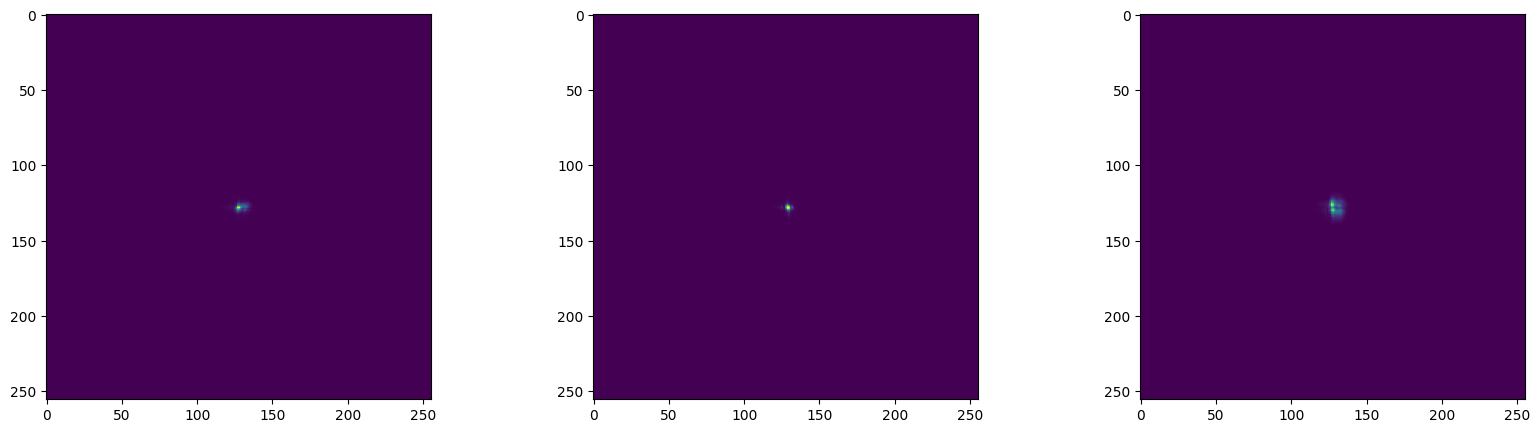

In [517]:
psfm = [None] * n_bias  # measured psf 
psfi = [None] * n_bias  # psf intensity
bg = 180  # camera's background
for i in range(n_bias):
    slm.setRO(i)
    psfm[i] = cam.snap()
#     psfm[i] = cam.grab(nframes=3, frame_timeout=5.0, missing_frame='skip', return_info=False, buff_size=None)
    psfm[i] = (psfm[i] - bg) * (psfm[i] > bg)
    psfm[i] = cp.array(psfm[i])
    psfi[i] = psfm[i] + 0j
        
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    if xp == cp:
        plt.imshow((psfm[i]).get())
    else:
        plt.imshow(psfm[i])


In [473]:
# for the starting test aberration
ri2 = (-18 * chs[1, 1] + 5 * chs[2, 2] - 7 * chs[3, 1] + 11 * chs[3, 3]) * circ / 4  # starting random input phase

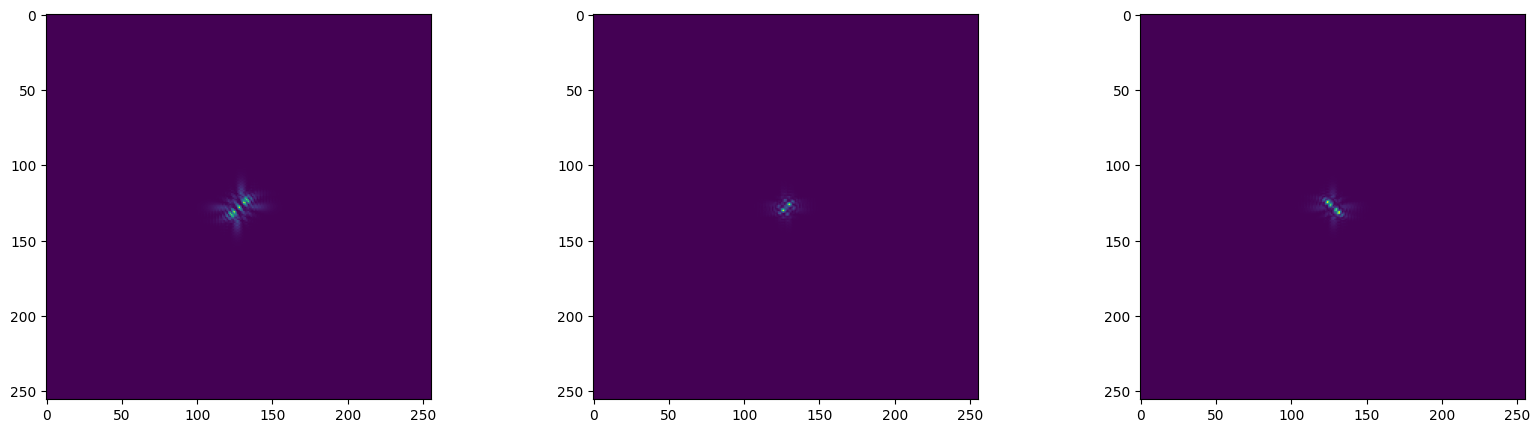

In [474]:
qq = [None] * n_bias
Q = circ * xp.exp(1j * ri2)
for ii in range(n_bias):
    qq[ii] = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[ii])))

plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    if xp == cp:
        plt.imshow((xp.abs(qq[i]) ** 2).get())
    else:
        plt.imshow(xp.abs(qq[i]) ** 2)


Work out measured PSFs for the 3 applied masks

## Iteration loop to correct aberrations

In [512]:
ab = xp.zeros((N, N))
qq = [None] * n_bias
QQ = [None] * n_bias

In [513]:
cuml_phase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)
abbD = xp.zeros((ND, ND))
cuml_c = xp.zeros(len(c_a_p))  # accumulated Chebyshev polynonials indices
let = 0  # last elapsed time
rms_plot = []

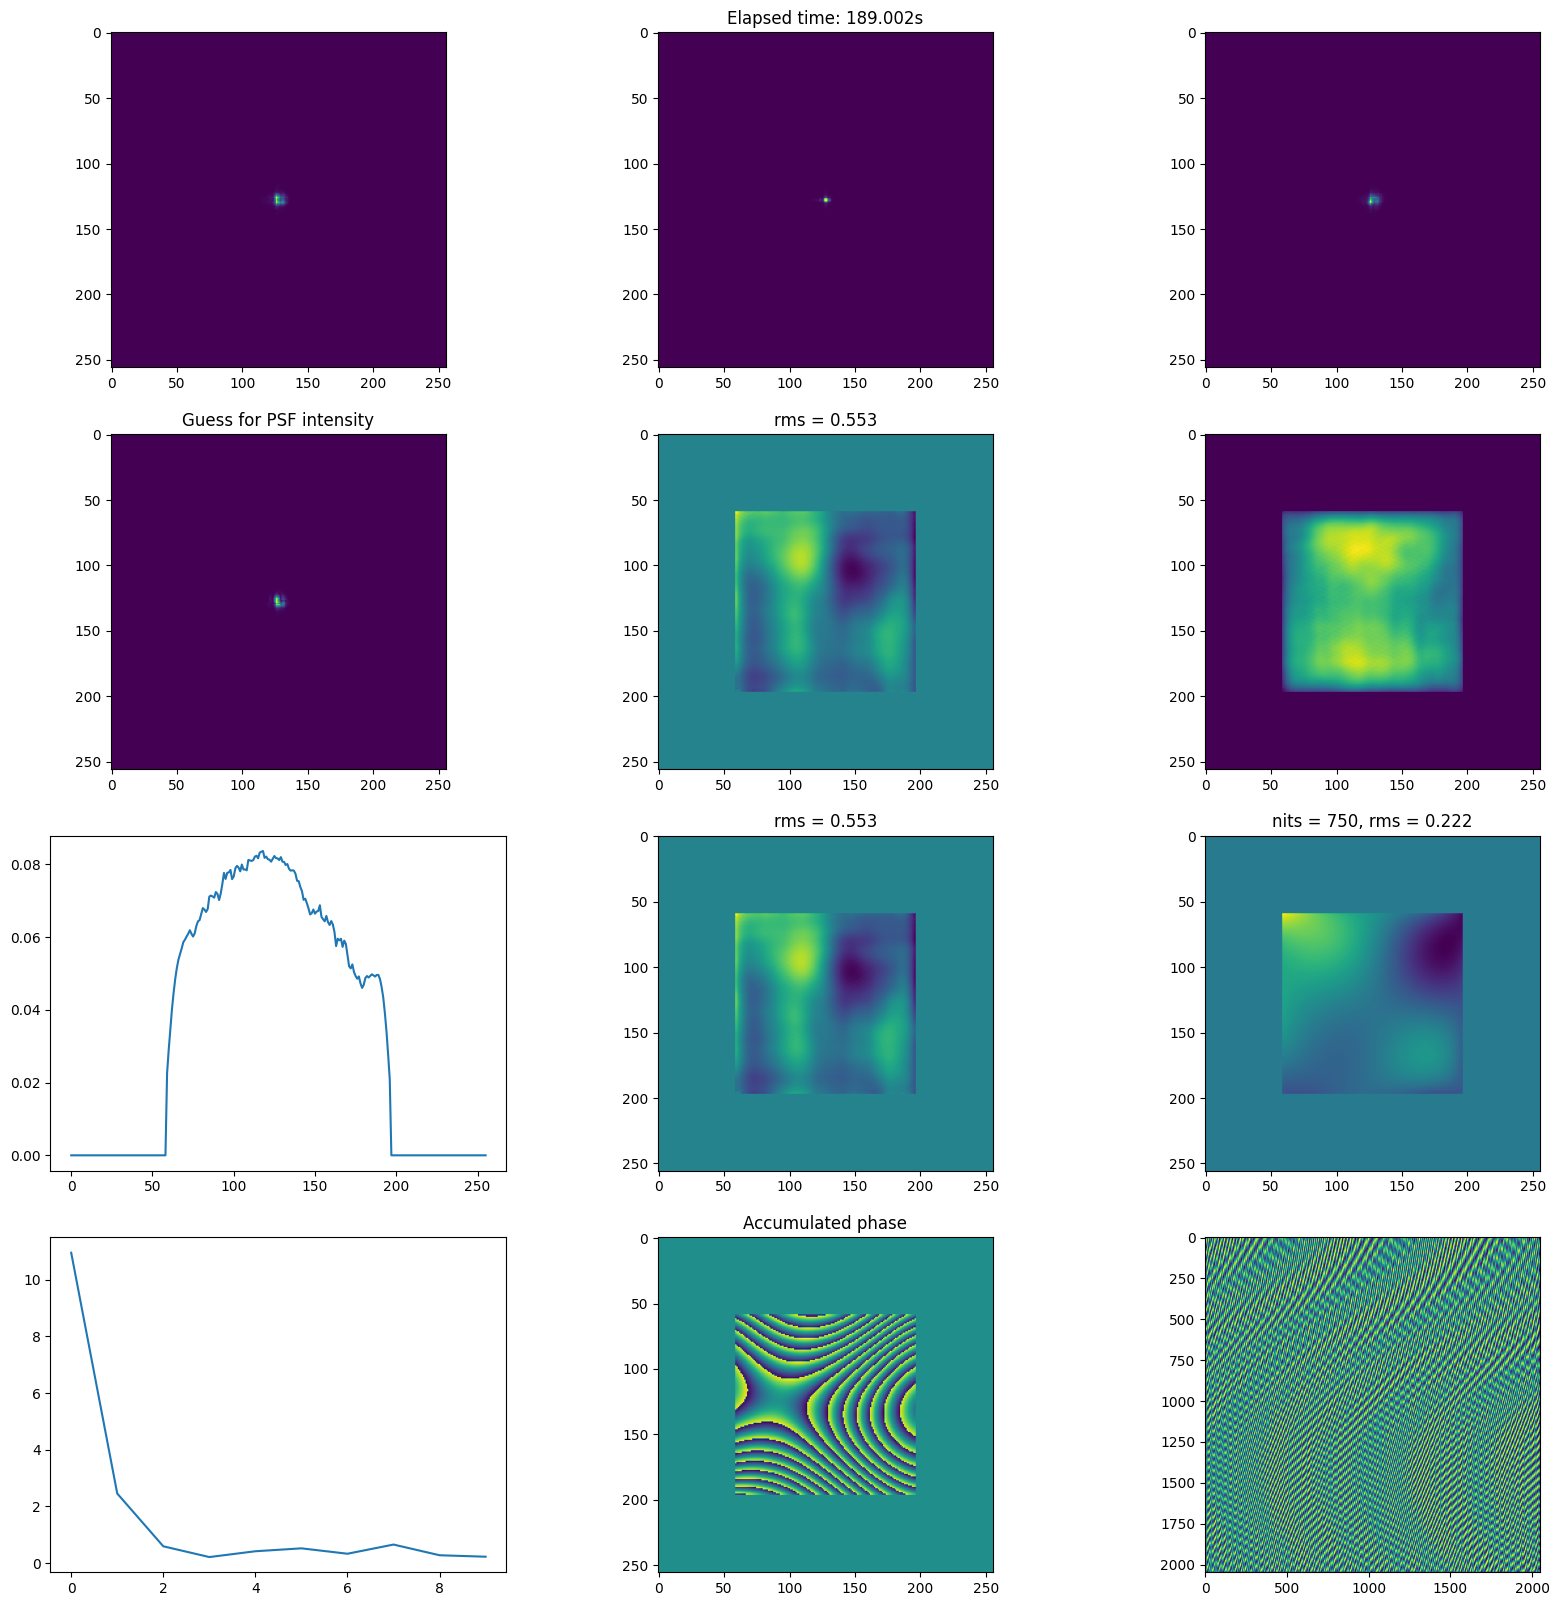

sending frame number 220
bitplane sent in 1.1452078819274902
sending frame number 221
bitplane sent in 1.113095760345459
sending frame number 222
bitplane sent in 1.0998902320861816
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\iter750_230531_172517.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48160 1ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-May-31 17:25:22

Creating "iter750_230531_172517.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10144
Repertoire updated in 16.81133246421814s
Order is set t

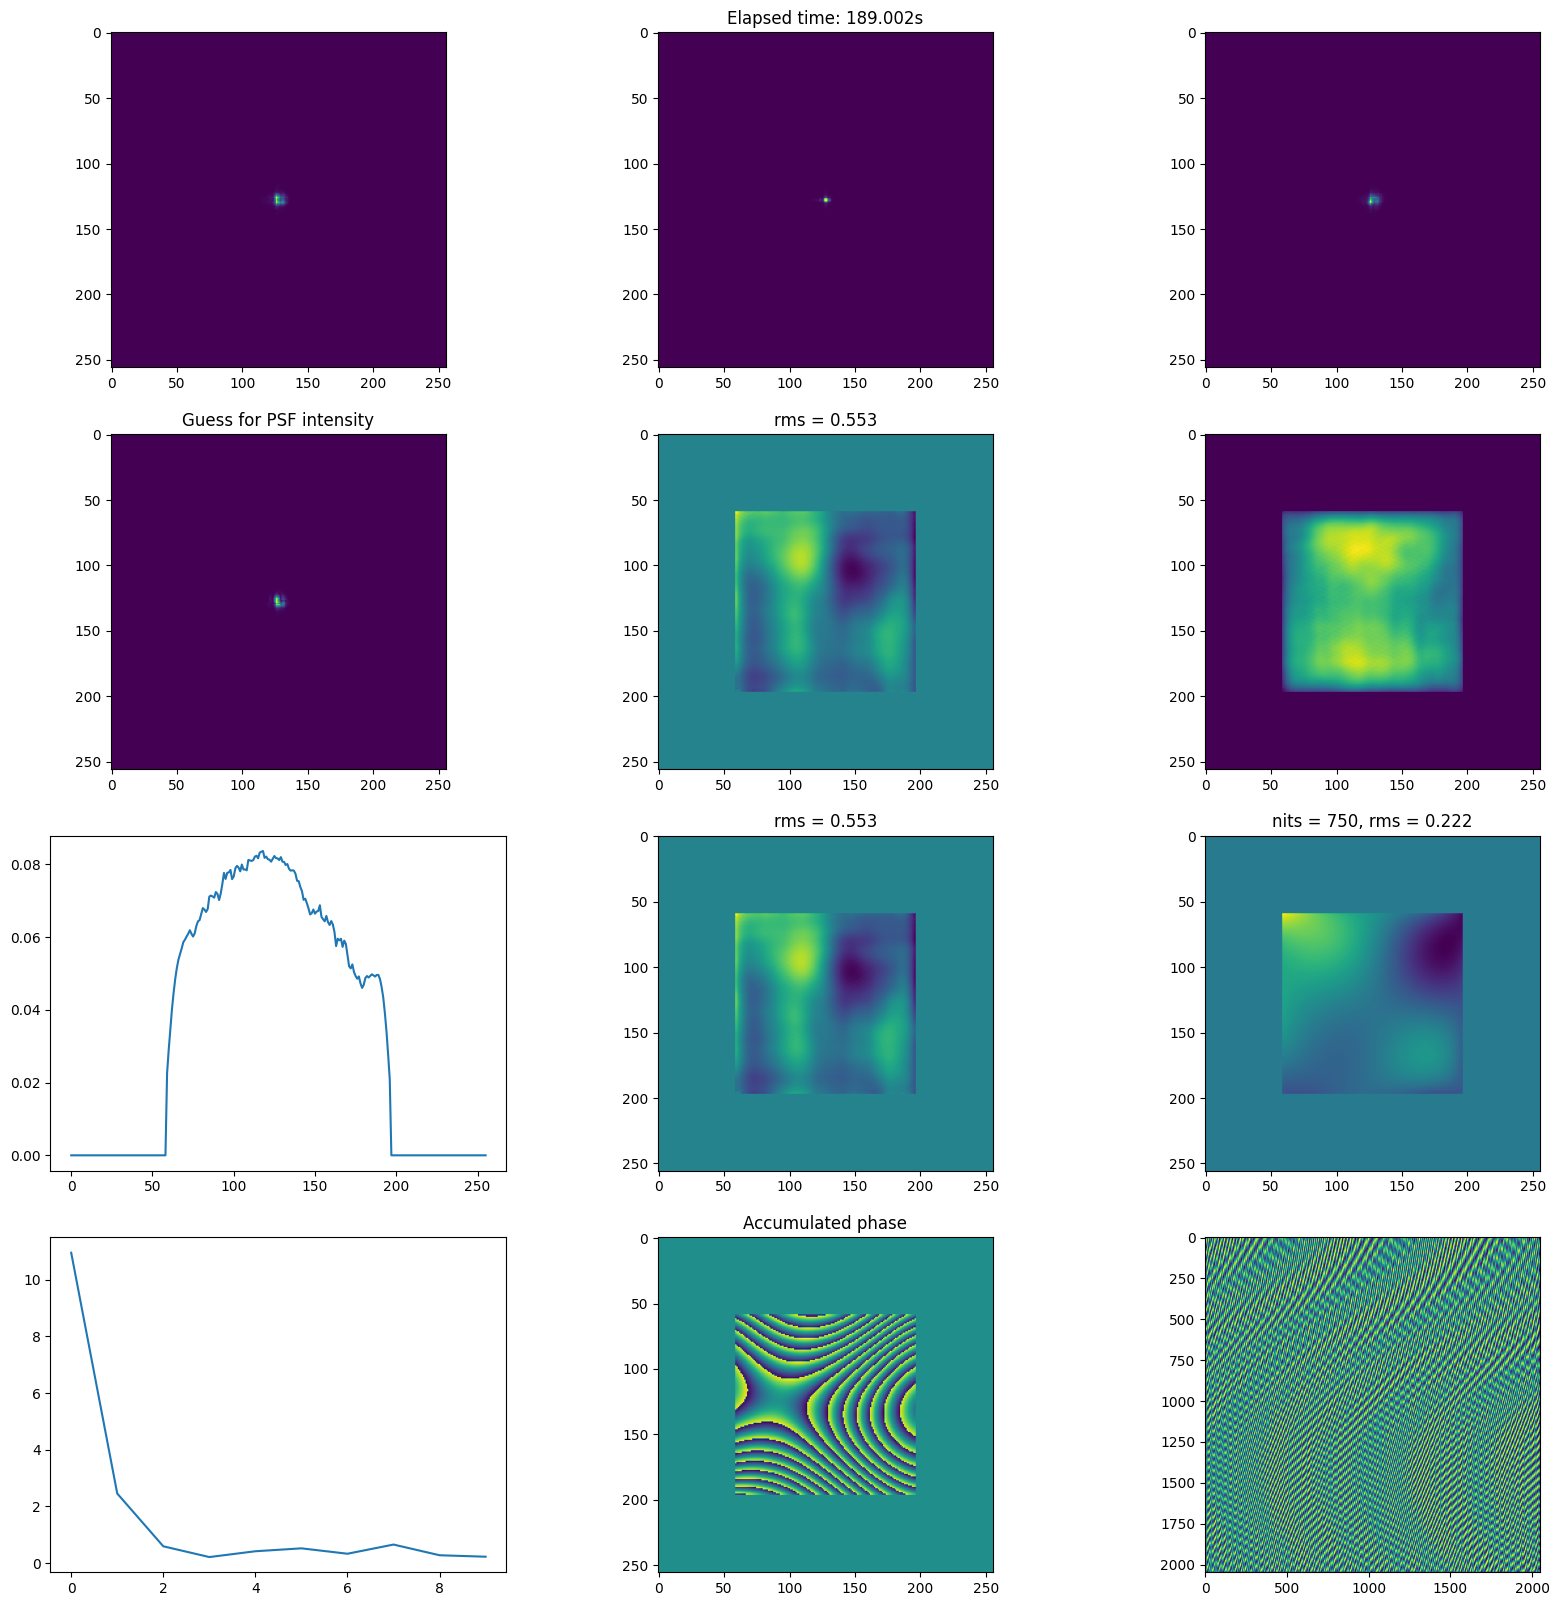

In [514]:
show_ani = True
if show_ani:
    f = plt.figure(figsize=(20,20))
#     f = plt.figure(figsize=(12,10))

    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        if not title is None:
            axes[k].set_title(title)
#             axes[k].set_title(title, fontsize=8)
        if k == (8 + n_bias):
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())

nits = 1
n = 75
do_int = False
last_rms = 10.0


t0 = time.time()

while nits < n * 20 + 1:
    for ii in range(n_bias):
        qq[ii] = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[ii])))
    
    if xp.mod(nits, n) == 0:
        show_animation(0, psfm[0])
        show_animation(1, psfm[1], f'Elapsed time: {let:.3f}s')
        show_animation(2, psfm[2])
        show_animation(3, xp.abs(qq[0]) ** 2, 'Guess for PSF intensity')
        
    Q = 0
    for i in range(n_bias):
        QQ[i] = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[i]) * xp.exp(1j * xp.angle(qq[i])))) 
        QQ[i] = QQ[i] * circ * xp.exp(-1j * bias[i])
        Q = Q + QQ[i]

    Qc = xp.angle(Q) * circ

    if xp.mod(nits, n) == 0:
        rms = xp.std(Qc[circ])
        show_animation(4, Qc, f'rms = {rms:.3f}')
        show_animation(5, abs(Q))

        if show_ani:
            axes[6].clear()
            if xp == cp:
                axes[6].plot(xp.squeeze(abs(Q.get()[N//2,:])))
            else:
                axes[6].plot(xp.squeeze(abs(Q[N//2,:])))

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    if do_int:
        c_i = oe.contract('ijk, jk, jk, i -> i', c_a_i, xp.abs(Q), wt, normval_i) 
        Qb = oe.contract('ijk, i -> jk', c_a_i, c_i)
    else:  # Set the amplitude to a uniform pupil if the phase is still changing a lot
        if last_rms < 2 * np.pi:
            do_int = True
        Qb = circ

    Q = Qb * xp.exp(1j * Qc)

    if xp.mod(nits, n) == 0:
        # Smooth the phase and grab new psfs after applying the partial correction

        # Unwrap the phase
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc = xp.flipud(Qc)
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.fliplr(Qc)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.flipud(xp.fliplr(Qc)) * circ

        rms_d = xp.std(Qc[circ])
        show_animation(7, Qc, f'rms = {rms_d:.3f}')

#         Qce0 = Qc[N / 2 - d_p // 2 - 1 : N / 2 + d_p // 2 + 1, N / 2 - d_p // 2 - 1 : N / 2 + d_p // 2 + 1]
# #         Qce = cpndimage.zoom(Qce0, N / Qce0.shape[0], order=0)
#         Qc_offs = (Qc.shape[0] - 2048) // 2
#         Qc_abb = Qc[Qc_offs:Qc_offs + 2048, Qc_offs:Qc_offs + 2048]

        # Constrain phase in pupil to have slowly varying values by fitting to Chebyshev
        diff_c = oe.contract('ijk, jk, jk, i -> i', c_a_p, Qc, wt, normval_p)
        diff = oe.contract('ijk,i->jk', c_a_p, diff_c)
        
        #subtract the fitted phase from our current pupil guess
        Q = Q * xp.exp(-1j * diff)

        # Calculate rms of fitted phase 
        rms_dz = np.std(diff)
        show_animation(8, diff, f'nits = {nits}, rms = {rms_dz:.3f}')
    
        # Plot the fitted RMS values so far
        if xp == cp:
            rms_plot.append(rms_dz.get())
        else:
            rms_plot.append(rms_dz)
        if show_ani:
            axes[9].clear()
            axes[9].plot(rms_plot)

        # calculate the cummulative Chebyshev values and reconstruct the cummulative phase
        cuml_c += diff_c
        cuml_phase = oe.contract('ijk,i->jk', c_a_p, cuml_c)
        show_animation(10, xp.angle(xp.exp(1j * cuml_phase)), 'Accumulated phase')    
        
        oe.contract('ijk,i->jk', c_a_pD, cuml_c, out = abbD)
        
#         with np.printoptions(precision=3, suppress=True):
#             print(cuml_z)
                
        # if xp == cp:
        #     abb = cpndimage.zoom(cumphase, int(N / d_p * slm.xpix / N), order=0)
        # else:
        #     abb = scipy.ndimage.zoom(cumphase, int(N / d_p * slm.xpix / N), order=0)

        # slm_offs = (abb.shape[0] - 2048) // 2
        # slm_abb = abb[slm_offs:slm_offs + 2048, slm_offs:slm_offs + 2048]
        
        # cumphase_interleaved = slm_abb[2048 - xp.array(slm.xv, dtype=int), xp.array(slm.yv, dtype=int)]
        
        # Recalculate the holograms 
        G = xp.exp(1j * (Tau - abbD + Psi))  # calculate the terms needed for summation
        Phi = np.pi * (xp.real(G) < 0) * circD
        
        show_animation(11, Phi[1])

        for k in range(n_bias):
            if xp == cp:
                img[k] = Phi[k].get()
            else:
                img[k] = Phi[k]
            hex_bits[k] = np.packbits(img[k].astype('int'), bitorder='little')
            timestamp = time.strftime("%y%m%d_%H%M%S", time.localtime())
        
        har.updateBp(hex_bits, f'iter{nits}_{timestamp}')
            
        # grab new psf images
        for i in range(n_bias):
            slm.setRO(i)
            psfm[i] = cam.snap()
            psfm[i] = (psfm[i] - bg) * (psfm[i] > bg)
            psfm[i] = cp.array(psfm[i])
            psfi[i] = psfm[i] + 0j

        # Stop if rms is small enough for two consecutive iterations
        if rms_dz < 0.4 and last_rms < 0.4:
            break
        else:
            last_rms = rms_dz      
        let = time.time() - t0
    nits = nits + 1

# with np.printoptions(precision=3, suppress=True):
#     print(cuml_z)
# print(f'Total rms phase = {xp.linalg.norm(cuml_z):.3f}')

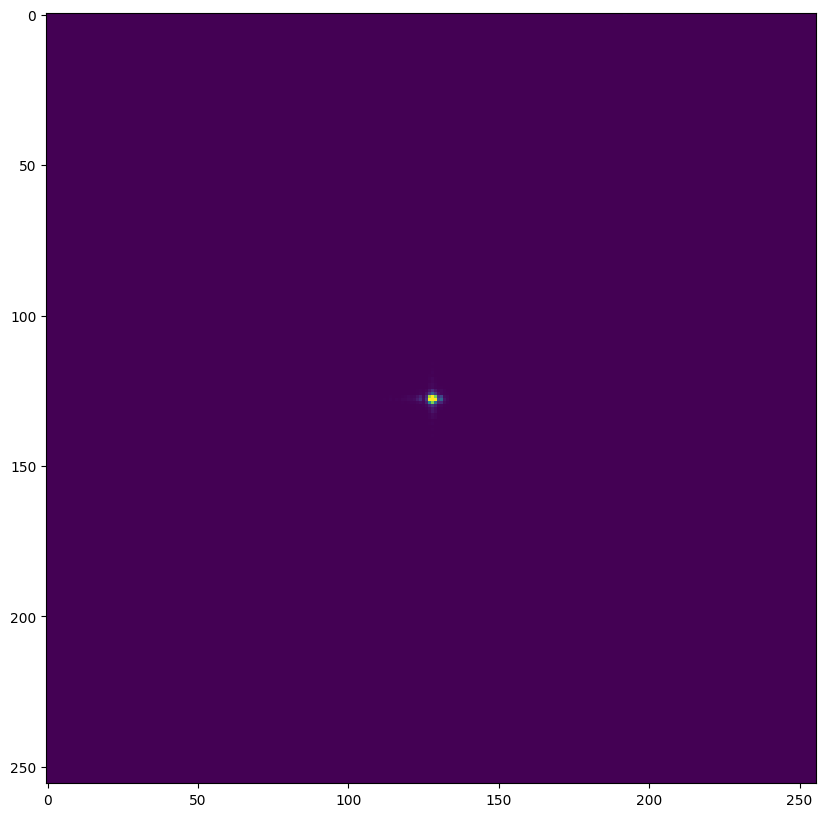

In [515]:
plt.figure(figsize=(10, 10))
plt.imshow(psfm[1].get())

In [61]:
xp.sum(circD)

array(4186116)

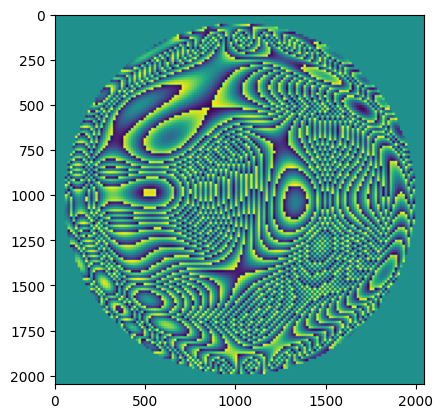

In [778]:
plt.imshow(xp.angle(xp.exp(1j * slm_abb)).get())

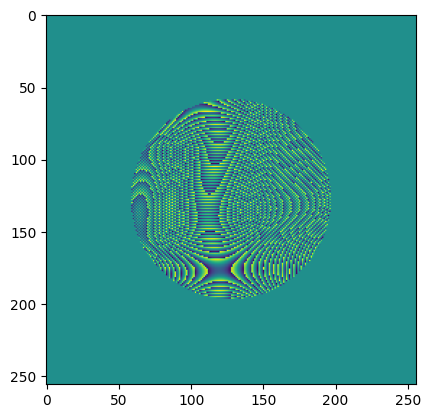

In [681]:
aaa = xp.angle(xp.exp(1j * ab))
plt.imshow(aaa.get())

(140, 140)


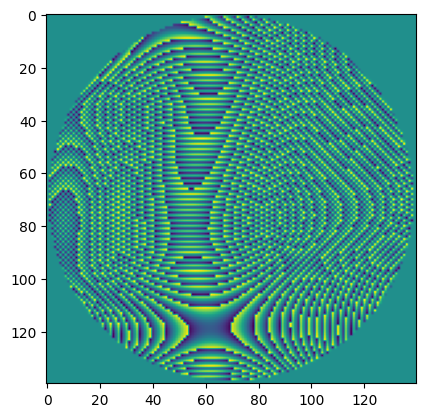

In [682]:
sss = aaa.shape[0]
bbb = aaa[sss / 2 - d_p // 2 - 1 : sss / 2 + d_p // 2 + 1, sss / 2 - d_p // 2 - 1 : sss / 2 + d_p // 2 + 1]
plt.imshow(bbb.get())
print(bbb.shape)

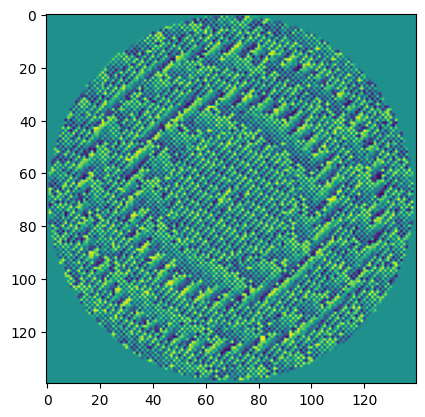

In [709]:
ccc = Qc[Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1, Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1]
plt.imshow(ccc.get())

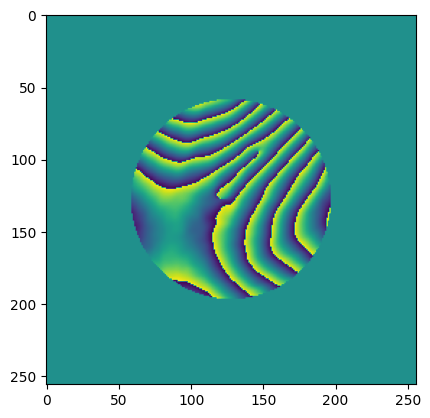

In [733]:
plt.imshow(Qc.get())

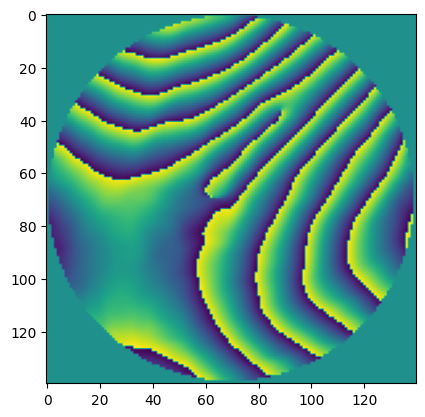

In [734]:
abc = Qc[Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1, Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1]
plt.imshow(abc.get())

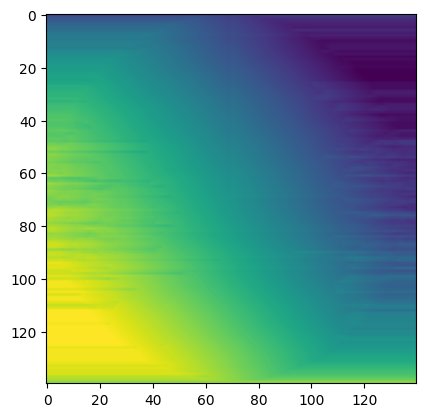

In [695]:
plt.imshow(Qce0.get())

140

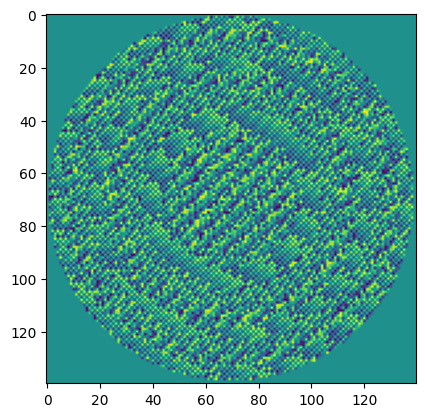

In [696]:
qqq = Qc[Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1, Qcs / 2 - d_p // 2 - 1 : Qcs / 2 + d_p // 2 + 1]
plt.imshow(qqq.get())
qqq.shape[0]

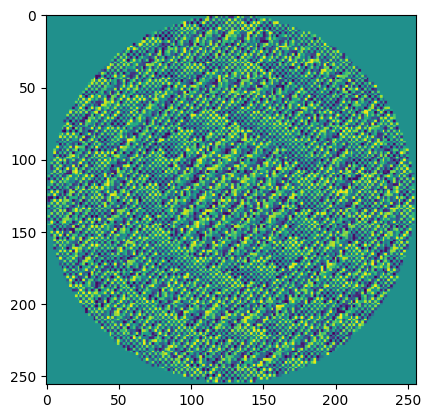

In [697]:
p0 = cpndimage.zoom(qqq, 256 / 140, order=0)
plt.imshow(p0.get())

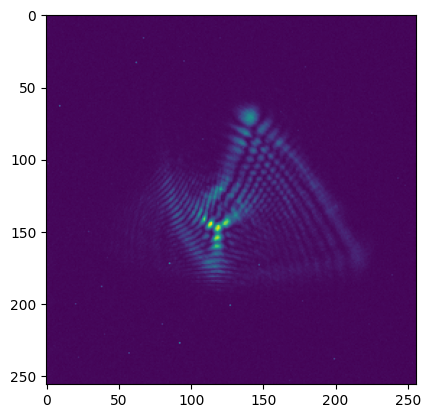

In [348]:
p0 = psfm[0].get()
plt.imshow(p0)

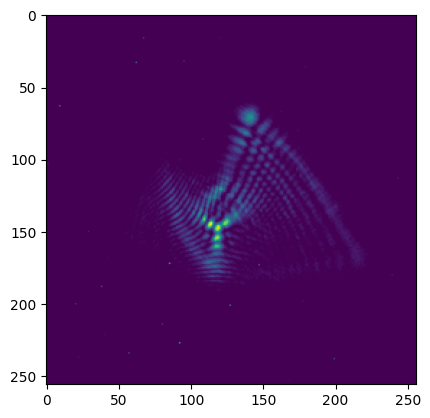

In [363]:
plt.imshow((p0 - 250) * (p0 > 250))

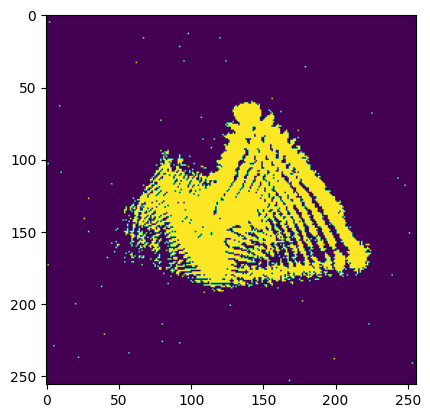

In [369]:
plt.imshow(p0 > 250)

In [350]:
psfm[2].max()

array(4184, dtype=uint16)

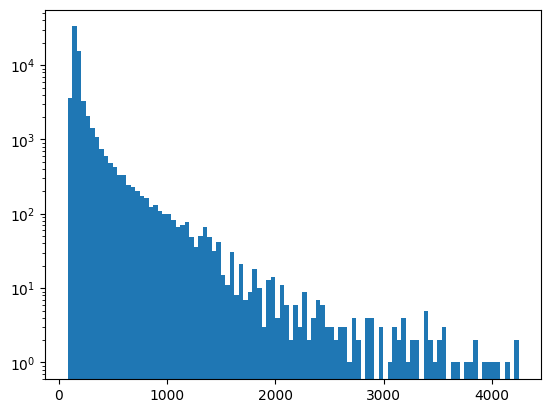

In [451]:
h = plt.hist(p0.flatten(), log=True, bins=100)

(256, 256)

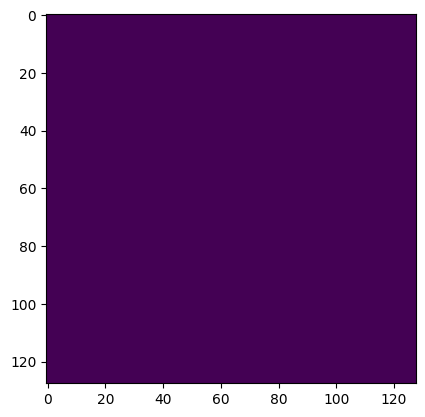

In [1145]:
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (cumphase))).get())
#     plt.imshow(cumphase.get())
# plt.figure()
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

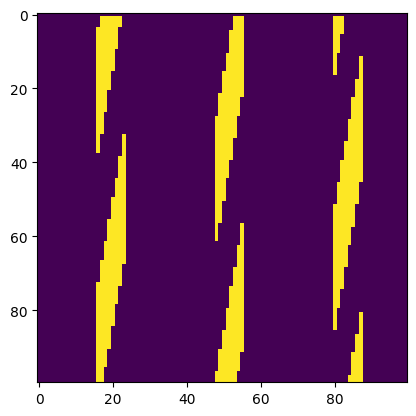

In [1155]:
plt.imshow(Phi[0].get()[:100, :100])

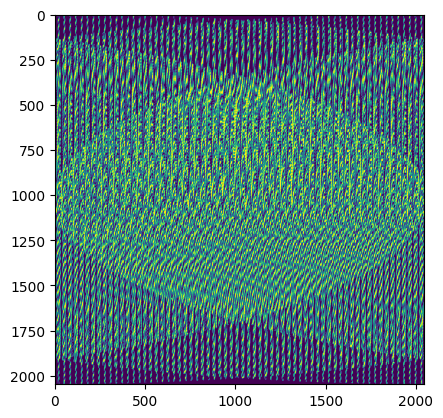

In [1201]:
plt.imshow(Phi[0].get())

In [872]:
print(rms)

17.9708566642901


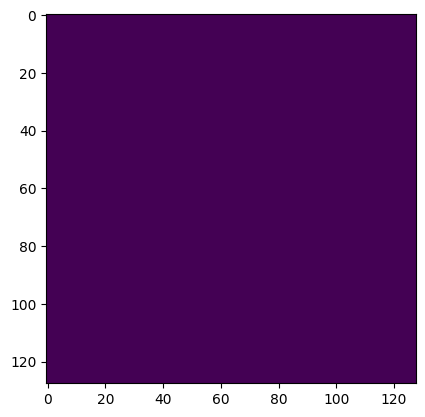

In [1144]:
plt.figure()
if xp == cp:
    plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

Text(0.5, 1.0, 'Random target phase')

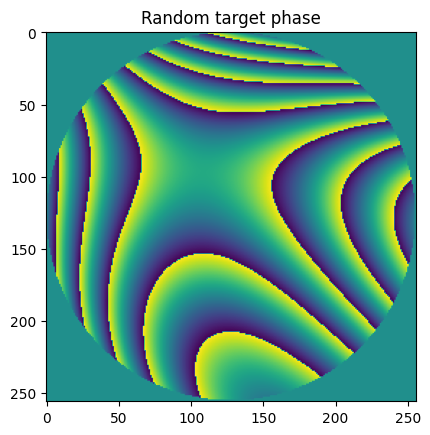

In [1191]:
plt.figure(100)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (ri))))
plt.title('Random target phase')

In [1192]:
# zs = xp.zeros((1,21))
# Qc = cumphase

# # Constrain phase in pupil to have slowly varying values by fitting to Zernike
# Z_list = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55, Z5_5]

# for i in range(21):
#     zs[0, i] = xp.sum(Qc * Z_list[i])
# zs = zs/normval

Tried to make the retrived phase bianary, but failed. The PSF is too good to believe.

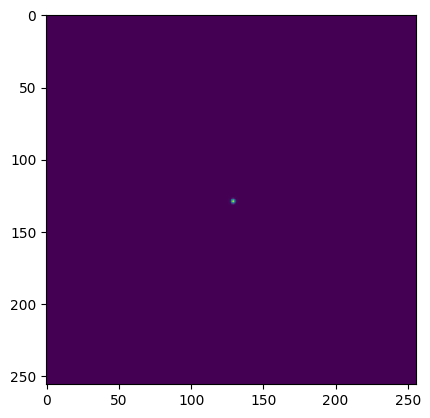

In [1193]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

In [757]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'ampl' is not defined

<Figure size 640x480 with 0 Axes>

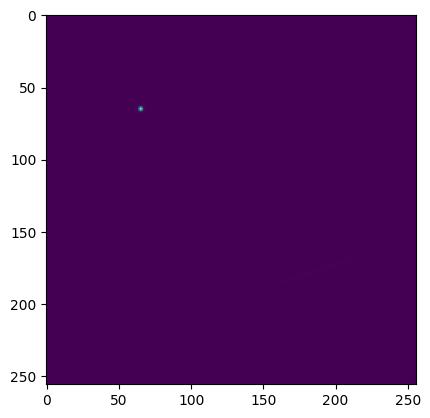

In [1195]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

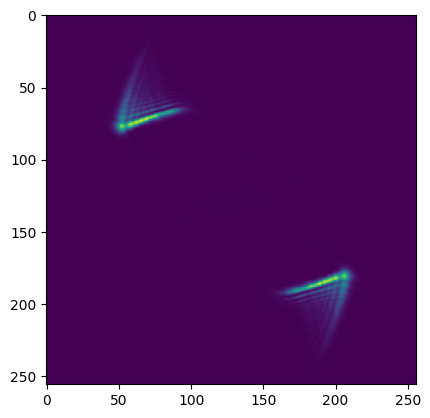

In [1196]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))